# Fatty acid
```
RM14/0001
```

In [1]:
!pip install fredapi

Defaulting to user installation because normal site-packages is not writeable


## Data preparation

In [2]:
import preprocessor as pre
import naiveforecastor as nf
import visualiser as visual
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Import data
palm_oil_df = pre.get_Fred_data('PPOILUSDM',2014,2024)

df = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Predicting_Price_Evolutions_202310.csv',2014,2023)

target = 'Fatty acid'.lower()

RM_codes = ["RM14/0001"]

external_drivers = {
    'PPOILUSDM': palm_oil_df
}

slicing_columns = ["PPOILUSDM","AR"]


In [3]:
# Impute raw data of target variables 
imputed_df, missing = pre.impute_pred_price_evo_csv(df)

# Slice date range for Naice Forecast
naive_df = imputed_df[imputed_df.Year >= 2016]
                      
## Feature engineering for Lasso
# Create dummy variables
dummy_df = pre.get_dummies_and_average_price(imputed_df,target,*RM_codes)

# Generate features
target_df = pre.generate_features(1,12,dummy_df,*RM_codes, **external_drivers)

target_df = target_df[target_df.Year >= 2016]
print(target_df.columns)

Index(['RM14/0001', 'Year', 'Month', 'Time', 'Group Description',
       'Average_price', 'PPOILUSDM_1', 'PPOILUSDM_2', 'PPOILUSDM_3',
       'PPOILUSDM_4', 'PPOILUSDM_5', 'PPOILUSDM_6', 'PPOILUSDM_7',
       'PPOILUSDM_8', 'PPOILUSDM_9', 'PPOILUSDM_10', 'PPOILUSDM_11',
       'PPOILUSDM_12', 'AR_1', 'AR_2', 'AR_3', 'AR_4', 'AR_5', 'AR_6', 'AR_7',
       'AR_8', 'AR_9', 'AR_10', 'AR_11', 'AR_12'],
      dtype='object')


## 1 Month Prediction

### Naive 1-month

MAPE of 1 month(s) fatty acid Naive Forecast: 0.109
MSE of 1 month(s) fatty acid Naive Forecast: 0.032


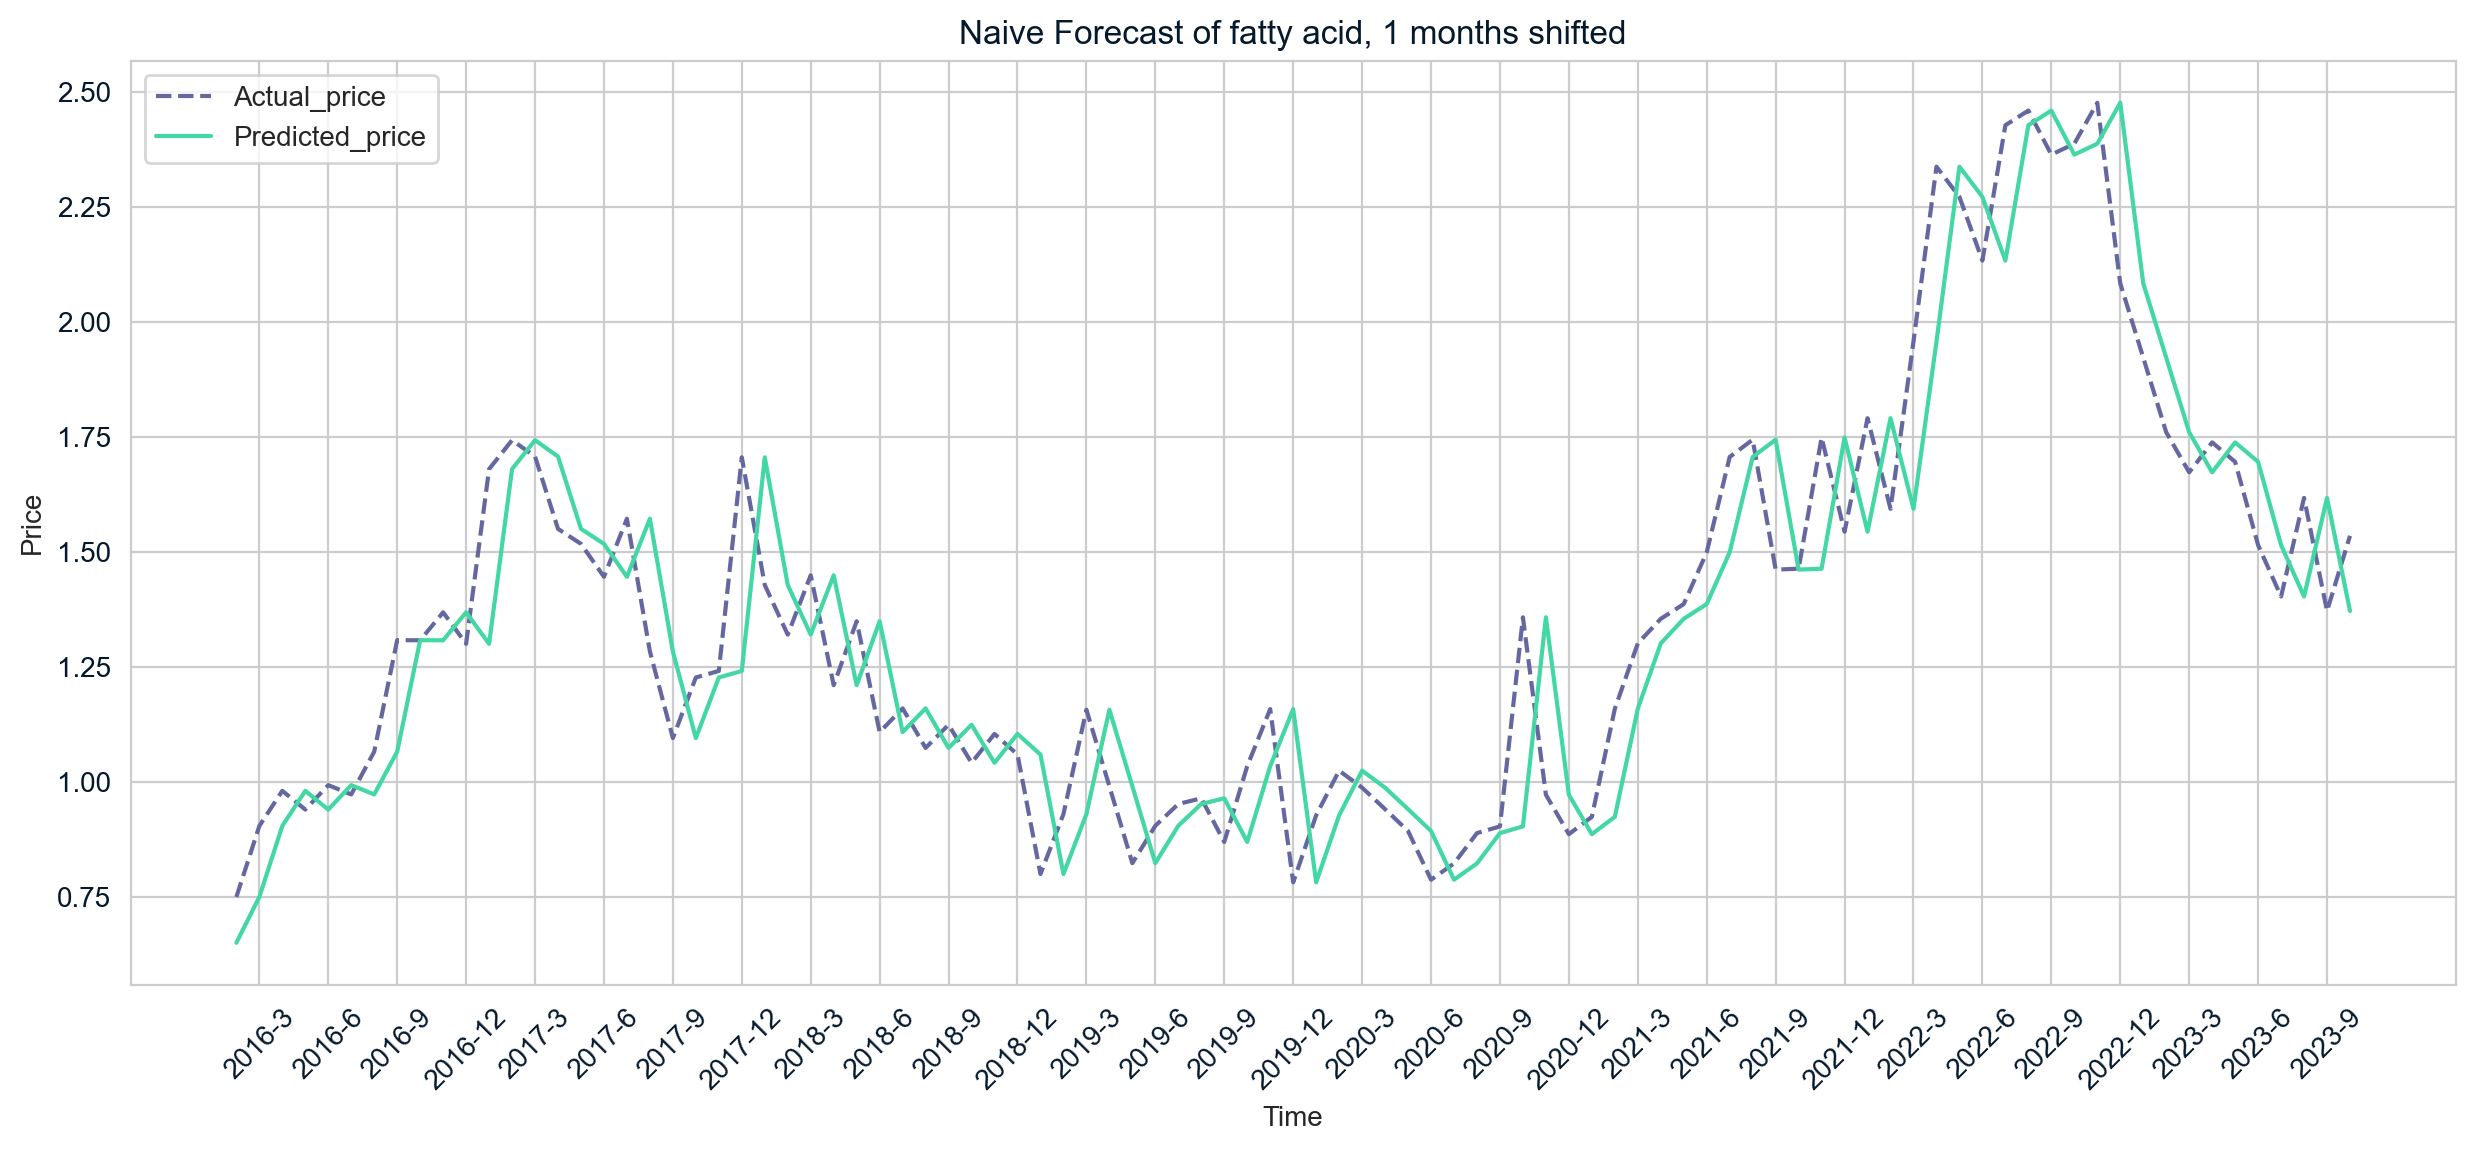

In [4]:
# Naive forecast
nf.naive_forest(naive_df,target,1,missing)


### Lasso 1-month

In [5]:
## train_test_split()
## Check data distribution
## Data scaling - log transformation and standardlisation

# Create X, y
feature_list = target_df.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X = feature_list.values
y = target_df['Average_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30% as test set

# Log transformation and standardlisation
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1,1))

In [6]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)



# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(feature_list.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(feature_list.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")
    
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_
    
# Calculate MAPE and MSE of training set
y_pred_train = best_lasso_model.predict(X_train_scaled)
y_pred_train_inverse = np.exp(scaler_y.inverse_transform(y_pred_train.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

print("MAPE, 1-month, train: ", round(mean_absolute_percentage_error(y_train,y_pred_train_inverse), 3))
print("MSE, 1-month, train: ", round(mean_squared_error(y_train,y_pred_train_inverse), 3))

Best alpha parameter: 0.010003433444481492
Best R-squared score: 0.824
Coefficients of the selected features in the best Lasso model:
RM14/0001: 0.0
PPOILUSDM_1: 0.171
PPOILUSDM_2: 0.0
PPOILUSDM_3: -0.0
PPOILUSDM_4: -0.0
PPOILUSDM_5: 0.0
PPOILUSDM_6: 0.115
PPOILUSDM_7: -0.0
PPOILUSDM_8: 0.0
PPOILUSDM_9: 0.0
PPOILUSDM_10: -0.0
PPOILUSDM_11: -0.0
PPOILUSDM_12: -0.0
AR_1: 0.579
AR_2: 0.0
AR_3: 0.008
AR_4: 0.064
AR_5: 0.088
AR_6: 0.0
AR_7: 0.004
AR_8: 0.0
AR_9: 0.0
AR_10: -0.205
AR_11: 0.202
AR_12: 0.0
MAPE, 1-month, train:  0.092
MSE, 1-month, train:  0.023


In [7]:
## Lasso regression - transform test data set
# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)
y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE, 1-month, test: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

# Best mean_squared_error
print("MSE, 1-month, test: ", round(mean_squared_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=0.010003433444481492)
Test Set R-squared score: 0.768
MAPE, 1-month, test:  0.111
MSE, 1-month, test:  0.039


In [8]:
## Lasso regression - complete 2023/10 data set

df_23 = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Predicting_Price_Evolutions_202310.csv',2014,2023)

imputed_df_23, missing_23 = pre.impute_pred_price_evo_csv(df_23)

dummy_df_23 = pre.get_dummies_and_average_price(imputed_df_23,target,*RM_codes)

target_df_23 = pre.generate_features(1,12,dummy_df_23,*RM_codes,**external_drivers)

# Create X, y
feature_list = target_df_23.drop(['Time', 'Group Description','Year','Month','Average_price'],\
                                  axis=1)
X_23 = feature_list.values
y_23 = target_df_23['Average_price'].values

# Log transformation and standardlisation
X_scaled_23 = scaler_x.transform(X_23)

# Predict new y
y_pred_23 = best_lasso_model.predict(X_scaled_23)
y_pred_23_inverse = np.exp(scaler_y.inverse_transform(y_pred_23.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Calculate MAPE
mape_23 = mean_absolute_percentage_error(y_23,y_pred_23_inverse)
print(f"MAPE, 1-month, complete 2023/10 dataset: {mape_23:.3f}")
mse_23 = mean_squared_error(y_23,y_pred_23_inverse)
# Best mean_squared_error
print(f"MSE, 1-month, complete 2023/10 dataset: {mse_23:.3f}")

MAPE, 1-month, complete 2023/10 dataset: 0.104
MSE, 1-month, complete 2023/10 dataset: 0.028


In [9]:
## Lasso regression - transform new data and match the predicted values with real values
# Get latest data

df_24 = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Future_Predicting_Price_Evolutions_202403.csv',2014,2024)

imputed_df_24, missing_24 = pre.impute_pred_price_evo_csv(df_24)

dummy_df_24 = pre.get_dummies_and_average_price(imputed_df_24,target,*RM_codes)

target_df_24 = pre.generate_features(1,12,dummy_df_24,*RM_codes,**external_drivers)

# Create X, y
feature_list = target_df_24.drop(['Time', 'Group Description','Year','Month','Average_price'],\
                                  axis=1)
X_24 = feature_list.values
y_24 = target_df_24['Average_price'].values

# Log transformation and standardlisation
X_scaled_24 = scaler_x.transform(X_24)

# Predict new y
y_pred_24 = best_lasso_model.predict(X_scaled_24)
y_pred_24_inverse = np.exp(scaler_y.inverse_transform(y_pred_24.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Calculate MAPE
mape_24 = mean_absolute_percentage_error(y_24,y_pred_24_inverse)
print(f"MAPE, 1-month, new data: {mape_24:.3f}")
mse_24 = mean_squared_error(y_24,y_pred_24_inverse)
# Best mean_squared_error
print(f"MSE, 1-month, new data: {mse_24:.3f}")

MAPE, 1-month, new data: 0.101
MSE, 1-month, new data: 0.027


## 3 months predictions

### Naive 3-month

MAPE of 3 month(s) fatty acid Naive Forecast: 0.153
MSE of 3 month(s) fatty acid Naive Forecast: 0.068


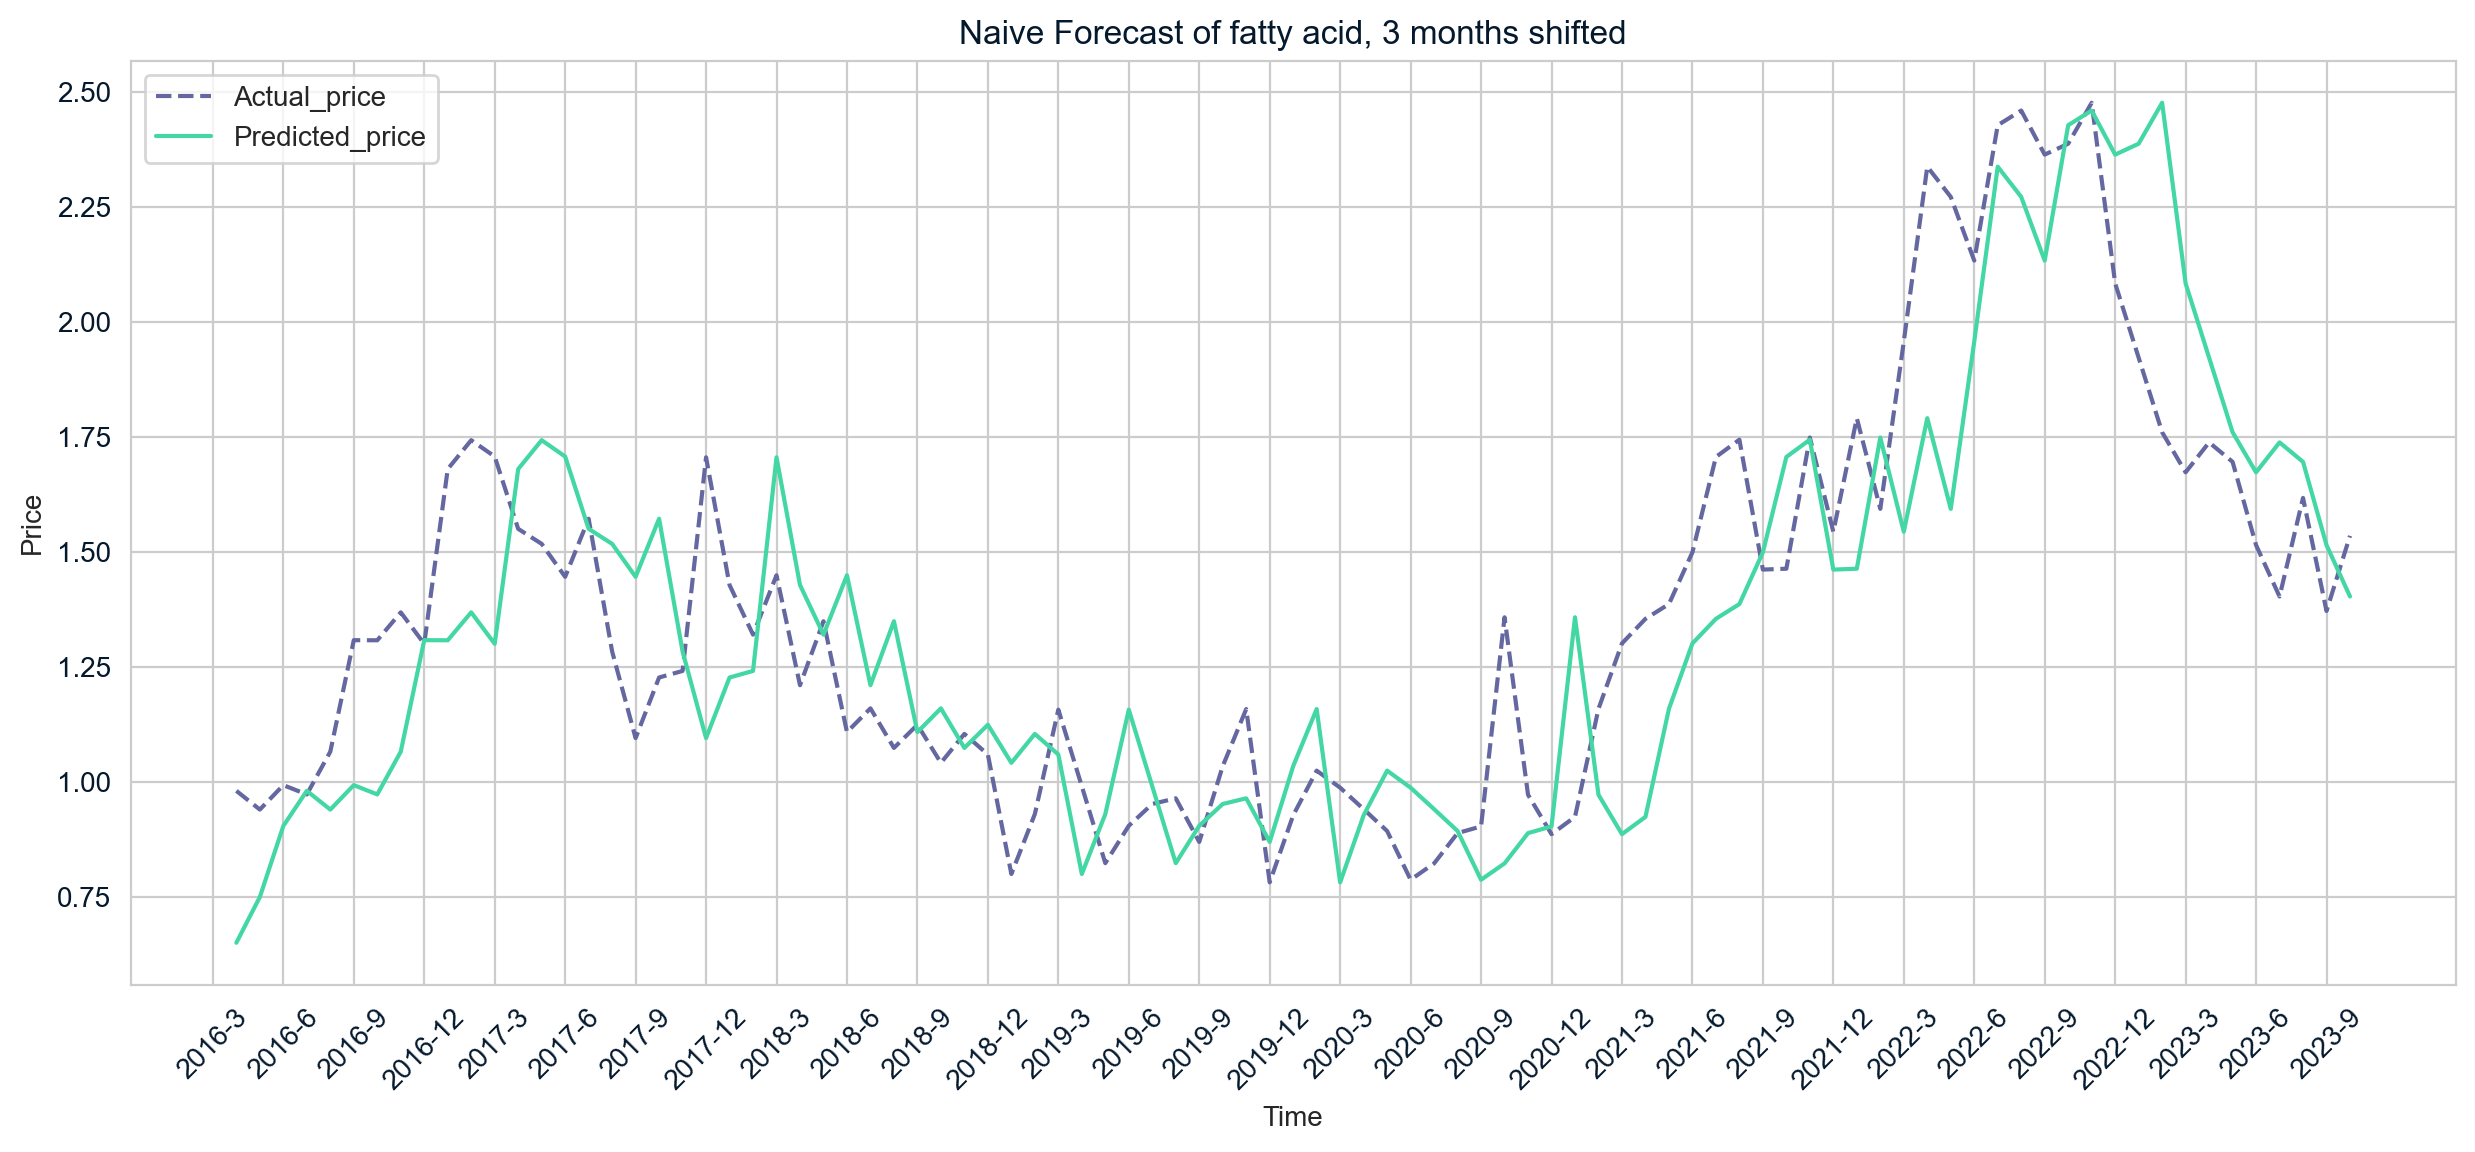

In [10]:
# Naive forecast
nf.naive_forest(naive_df,target,3,missing)

### Lasso 3-month

In [11]:
## train_test_split()
## Check data distribution
## Data scaling - log transformation and standardlisation

# Slice data for 3-month lag
try:
    for feature in slicing_columns:
         target_df=target_df.drop([f"{feature}_{i}" for i in range(1,3)], axis=1, errors='ignore')
    
    assert not any(col.endswith(("_1", "_2" )) for col in target_df.columns) , "df not sliced correctly"
except AssertionError:
    print("Unable to slice DataFrame")

# Create X, y
feature_list = target_df.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X = feature_list.values
y = target_df['Average_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30% as test set

# Log transformation and standardlisation
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1,1))

In [12]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)



# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(feature_list.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(feature_list.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")
    
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_
    
# Calculate MAPE and MSE of training set
y_pred_train = best_lasso_model.predict(X_train_scaled)
y_pred_train_inverse = np.exp(scaler_y.inverse_transform(y_pred_train.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

print("MAPE, 3-month, train: ", round(mean_absolute_percentage_error(y_train,y_pred_train_inverse), 3))
print("MSE, 3-month, train: ", round(mean_squared_error(y_train,y_pred_train_inverse), 3))

Best alpha parameter: 0.04134721157052351
Best R-squared score: 0.757
Coefficients of the selected features in the best Lasso model:
RM14/0001: 0.0
PPOILUSDM_3: 0.259
PPOILUSDM_4: 0.0
PPOILUSDM_5: 0.0
PPOILUSDM_6: 0.275
PPOILUSDM_7: 0.0
PPOILUSDM_8: 0.0
PPOILUSDM_9: 0.0
PPOILUSDM_10: 0.0
PPOILUSDM_11: 0.0
PPOILUSDM_12: 0.0
AR_3: 0.18
AR_4: 0.042
AR_5: 0.183
AR_6: 0.01
AR_7: 0.0
AR_8: 0.0
AR_9: 0.0
AR_10: 0.0
AR_11: 0.0
AR_12: 0.0
MAPE, 3-month, train:  0.11
MSE, 3-month, train:  0.034


In [13]:
## Lasso regression - transform test data set
# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)
y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE, 3-month, test: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

# Best mean_squared_error
print("MSE, 3-month, test: ", round(mean_squared_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=0.04134721157052351)
Test Set R-squared score: 0.721
MAPE, 3-month, test:  0.113
MSE, 3-month, test:  0.034


In [14]:
## Lasso regression - complete 2023/10 dataset based on trained model
# Get latest data

df_23 = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Predicting_Price_Evolutions_202310.csv',2014,2023)

imputed_df_23, missing_23 = pre.impute_pred_price_evo_csv(df_23)

dummy_df_23 = pre.get_dummies_and_average_price(imputed_df_23,target,*RM_codes)

target_df_23 = pre.generate_features(1,12,dummy_df_23,*RM_codes,**external_drivers)

# Slice data for 3-month lag
try:
    for feature in slicing_columns:
         target_df_23=target_df_23.drop([f"{feature}_{i}" for i in range(1,3)], axis=1, errors='ignore')
    
    assert not any(col.endswith(("_1", "_2" )) for col in target_df_23.columns) , "df not sliced correctly"
except AssertionError:
    print("Unable to slice DataFrame")


# Create X, y
feature_list = target_df_23.drop(['Time', 'Group Description','Year','Month','Average_price'],\
                                  axis=1)
X_23 = feature_list.values
y_23 = target_df_23['Average_price'].values

# Log transformation and standardlisation
X_scaled_23 = scaler_x.transform(X_23)

# Predict new y
y_pred_23 = best_lasso_model.predict(X_scaled_23)
y_pred_23_inverse = np.exp(scaler_y.inverse_transform(y_pred_23.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Calculate MAPE
mape_23 = mean_absolute_percentage_error(y_23,y_pred_23_inverse)
print(f"MAPE, 3-month, complete 2023/10 dataset: {mape_23:.3f}")
mse_23 = mean_squared_error(y_23,y_pred_23_inverse)
# Best mean_squared_error
print(f"MSE, 3-month, complete 2023/10 dataset: {mse_23:.3f}")

MAPE, 3-month, complete 2023/10 dataset: 0.121
MSE, 3-month, complete 2023/10 dataset: 0.035


In [15]:
## Lasso regression - transform new data and match the predicted values with real values
# Get latest data

df_24 = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Future_Predicting_Price_Evolutions_202403.csv',2014,2024)

imputed_df_24, missing_24 = pre.impute_pred_price_evo_csv(df_24)

dummy_df_24 = pre.get_dummies_and_average_price(imputed_df_24,target,*RM_codes)

target_df_24 = pre.generate_features(1,12,dummy_df_24,*RM_codes,**external_drivers)

# Slice data for 3-month lag
try:
    for feature in slicing_columns:
         target_df_24=target_df_24.drop([f"{feature}_{i}" for i in range(1,3)], axis=1, errors='ignore')
    
    assert not any(col.endswith(("_1", "_2" )) for col in target_df_24.columns) , "df not sliced correctly"
except AssertionError:
    print("Unable to slice DataFrame")


# Create X, y
feature_list = target_df_24.drop(['Time', 'Group Description','Year','Month','Average_price'],\
                                  axis=1)
X_24 = feature_list.values
y_24 = target_df_24['Average_price'].values

# Log transformation and standardlisation
X_scaled_24 = scaler_x.transform(X_24)

# Predict new y
y_pred_24 = best_lasso_model.predict(X_scaled_24)
y_pred_24_inverse = np.exp(scaler_y.inverse_transform(y_pred_24.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Calculate MAPE
mape_24 = mean_absolute_percentage_error(y_24,y_pred_24_inverse)
print(f"MAPE, 3-month, new data: {mape_24:.3f}")
mse_24 = mean_squared_error(y_24,y_pred_24_inverse)
# Best mean_squared_error
print(f"MSE, 3-month, new data: {mse_24:.3f}")

MAPE, 3-month, new data: 0.119
MSE, 3-month, new data: 0.034


## 6-month prediction

### Naive 6-month

MAPE of 6 month(s) fatty acid Naive Forecast: 0.210
MSE of 6 month(s) fatty acid Naive Forecast: 0.141


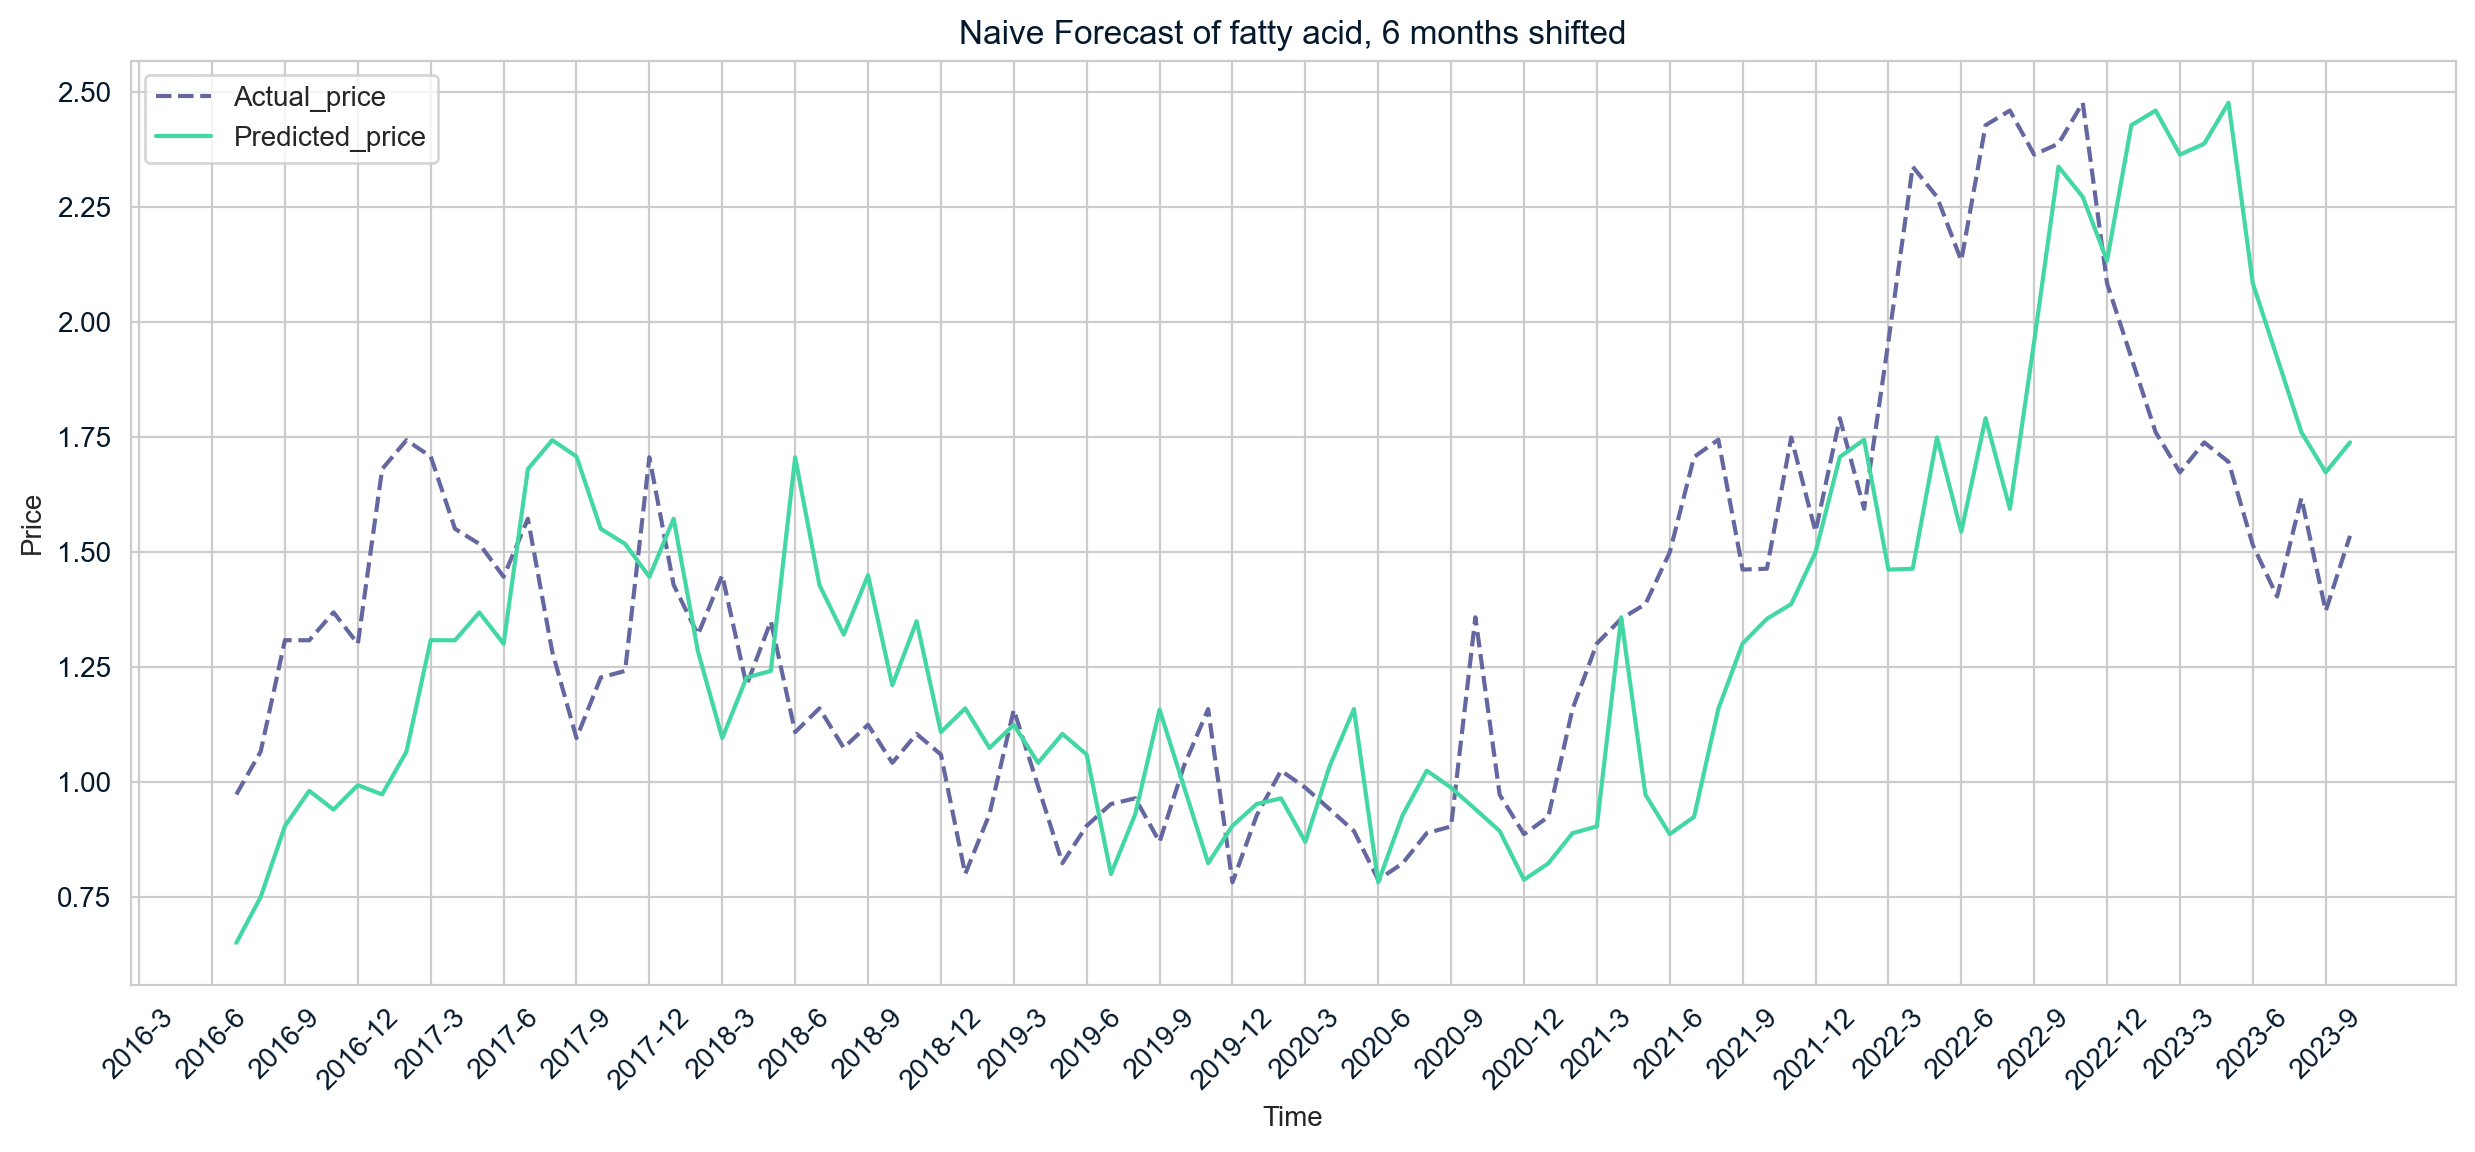

In [16]:
# Naive forecast
nf.naive_forest(naive_df,target,6,missing)

### Lasso 6-month

In [17]:
## train_test_split()
## Check data distribution
## Data scaling - log transformation and standardlisation

# Slice data for 6-month lag
try:
    for feature in slicing_columns:
         target_df=target_df.drop([f"{feature}_{i}" for i in range(1,6)], axis=1, errors='ignore')
    
    assert not any(col.endswith(("_1", "_2", "_3", "_4", "_5" )) for col in target_df.columns) , "df not sliced correctly"
except AssertionError:
    print("Unable to slice DataFrame")
    
# Create X, y
feature_list = target_df.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X = feature_list.values
y = target_df['Average_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30% as test set

# Log transformation and standardlisation
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1,1))

In [18]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)



# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(feature_list.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(feature_list.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")
    
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_
    
# Calculate MAPE and MSE of training set
y_pred_train = best_lasso_model.predict(X_train_scaled)
y_pred_train_inverse = np.exp(scaler_y.inverse_transform(y_pred_train.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

print("MAPE, 6-month, train: ", round(mean_absolute_percentage_error(y_train,y_pred_train_inverse), 3))
print("MSE, 6-month, train: ", round(mean_squared_error(y_train,y_pred_train_inverse), 3))

Best alpha parameter: 0.05068365611870624
Best R-squared score: 0.718
Coefficients of the selected features in the best Lasso model:
RM14/0001: 0.0
PPOILUSDM_6: 0.582
PPOILUSDM_7: 0.0
PPOILUSDM_8: 0.0
PPOILUSDM_9: 0.012
PPOILUSDM_10: 0.113
PPOILUSDM_11: 0.007
PPOILUSDM_12: 0.0
AR_6: 0.177
AR_7: 0.0
AR_8: 0.0
AR_9: 0.0
AR_10: 0.0
AR_11: 0.0
AR_12: 0.0
MAPE, 6-month, train:  0.122
MSE, 6-month, train:  0.043


In [19]:
## Lasso regression - transform test data set
# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)
y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE, 6-month, test: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

# Best mean_squared_error
print("MSE, 6-month, test: ", round(mean_squared_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=0.05068365611870624)
Test Set R-squared score: 0.582
MAPE, 6-month, test:  0.148
MSE, 6-month, test:  0.055


In [20]:
## Lasso regression - complete 2023/10 dataset based on trained model

df_23 = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Predicting_Price_Evolutions_202310.csv',2014,2023)

imputed_df_23, missing_23 = pre.impute_pred_price_evo_csv(df_23)

dummy_df_23 = pre.get_dummies_and_average_price(imputed_df_23,target,*RM_codes)

target_df_23 = pre.generate_features(1,12,dummy_df_23,*RM_codes,**external_drivers)

# Slice data for 6-month lag
try:
    for feature in slicing_columns:
         target_df_23=target_df_23.drop([f"{feature}_{i}" for i in range(1,6)], axis=1, errors='ignore')
    
    assert not any(col.endswith(("_1", "_2", "_3", "_4", "_5" )) for col in target_df_23.columns) , "df not sliced correctly"
except AssertionError:
    print("Unable to slice DataFrame")


# Create X, y
feature_list = target_df_23.drop(['Time', 'Group Description','Year','Month','Average_price'],\
                                  axis=1)
X_23 = feature_list.values
y_23 = target_df_23['Average_price'].values

# Log transformation and standardlisation
X_scaled_23 = scaler_x.transform(X_23)

# Predict new y
y_pred_23 = best_lasso_model.predict(X_scaled_23)
y_pred_23_inverse = np.exp(scaler_y.inverse_transform(y_pred_23.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Calculate MAPE
mape_23 = mean_absolute_percentage_error(y_23,y_pred_23_inverse)
print(f"MAPE, 6-month, complete 2023/10 dataset: {mape_23:.3f}")
mse_23 = mean_squared_error(y_23,y_pred_23_inverse)
# Best mean_squared_error
print(f"MSE, 6-month, complete 2023/10 dataset: {mse_23:.3f}")

MAPE, 6-month, complete 2023/10 dataset: 0.140
MSE, 6-month, complete 2023/10 dataset: 0.049


In [21]:
## Lasso regression - transform new data and match the predicted values with real values
# Get latest data

df_24 = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Future_Predicting_Price_Evolutions_202403.csv',2014,2024)

imputed_df_24, missing_24 = pre.impute_pred_price_evo_csv(df_24)

dummy_df_24 = pre.get_dummies_and_average_price(imputed_df_24,target,*RM_codes)

target_df_24 = pre.generate_features(1,12,dummy_df_24,*RM_codes,**external_drivers)

# Slice data for 6-month lag
try:
    for feature in slicing_columns:
         target_df_24=target_df_24.drop([f"{feature}_{i}" for i in range(1,6)], axis=1, errors='ignore')
    
    assert not any(col.endswith(("_1", "_2", "_3", "_4", "_5" )) for col in target_df_24.columns) , "df not sliced correctly"
except AssertionError:
    print("Unable to slice DataFrame")

    
# Create X, y
feature_list = target_df_24.drop(['Time', 'Group Description','Year','Month','Average_price'],\
                                  axis=1)
X_24 = feature_list.values
y_24 = target_df_24['Average_price'].values

# Log transformation and standardlisation
X_scaled_24 = scaler_x.transform(X_24)

# Predict new y
y_pred_24 = best_lasso_model.predict(X_scaled_24)
y_pred_24_inverse = np.exp(scaler_y.inverse_transform(y_pred_24.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Calculate MAPE
mape_24 = mean_absolute_percentage_error(y_24,y_pred_24_inverse)
print(f"MAPE, 6-month, new data: {mape_24:.3f}")
mse_24 = mean_squared_error(y_24,y_pred_24_inverse)
# Best mean_squared_error
print(f"MSE, 6-month, new data: {mse_24:.3f}")

MAPE, 6-month, new data: 0.137
MSE, 6-month, new data: 0.047
